Assignment 2: Approximation and Model-Free Reinforcement Learning


Name: **Aesha Gandhi**

Welcome to Assignment 2. This notebook will help you understand:
- Linear function approximation.
- Monte Carlo averaging.
- Temporal difference learning.
- Control with Q-learning.


## Preliminaries
You'll need three imports to complete this assignment:
- numpy: The fundamental package for scientific computing with Python.
- matplotlib: Used for scientific visualization of data in Python.
- gymnasium: A ubiquitous library for standard environments for reinforcement learning.
```console
pip install gymnasium
```
- gridworld: A module containing the 4x3 GridWorld we've been working with.
- pygame: A module required for visualizaing the cartpole environment.
```console
pip install pygame
```
- tools: A module for plotting.

Please do not change the imports and answer the written questions in a separate document. If you run into issues installing the libraries please let us know ASAP.

In [12]:
!pip install -q gymnasium
!pip install -q pygame
!pip install -q matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
%%capture
%matplotlib inline

In [14]:
import copy
import numpy as np
import gymnasium as gym
from gridworld import GridWorld, optimal_policy
from tools import plot_gridworld_u, plot_greedy_policy, visualize_random, visualize_q_weight_policy, plot_policy

## Section 1: Function Approximation with Samples and Features

Previously in the 4x3 GridWorld, each state was represented by an _index_. In more realistic settings (like for localization in robotics), we would represent state as a **feature vector** of length $k$, defined by the function $\phi$:
$$\phi: S \rightarrow \mathbb{R}^k$$
We'll be defining our own $\phi$ for the 4x3 GridWorld. Our feature vectors will be 4 + 3 + 3 dimensional binary vectors (a vector with only 0s and 1s), where the first 4 elements are a one-hot representation of the x-position of the agent, while the next 3 elements are a one-hot representation of the y-position of the agent. The last three features in the vector are binary variables representing the -1, +1 states and an additional terminating state. **For your convenience (and for compliance with the Gymnasium API), the state space of the environment is now 13, instead of 11 in your previous assignment. Refer to the image below.**.
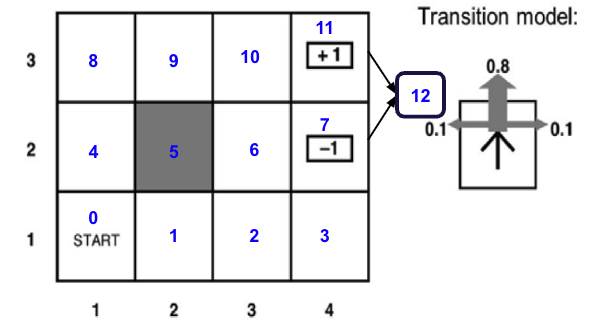

So for example, the start state (index 0) feature vector would be:
$$\phi(0) = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],$$
state 6 will be:
$$\phi(6) = [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],$$
the -1 rewarding state (index 7 in this new, 13-dimensional state space) would be:
$$\phi(7) = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],$$
and the terminating state would be:
$$\phi(12) = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1].$$
We include this extra terminal state to comply with the Gymnasium API and to keep our reward function definition consistent.

In this new setting, we're treating our `FeatureGridWorld` class below as a _simulator_ of the 4x3 GridWorld. This means that an agent will  receive sampled features of the state of the underlying MDP, and interact with this MDP by taking _actions_ in the MDP:

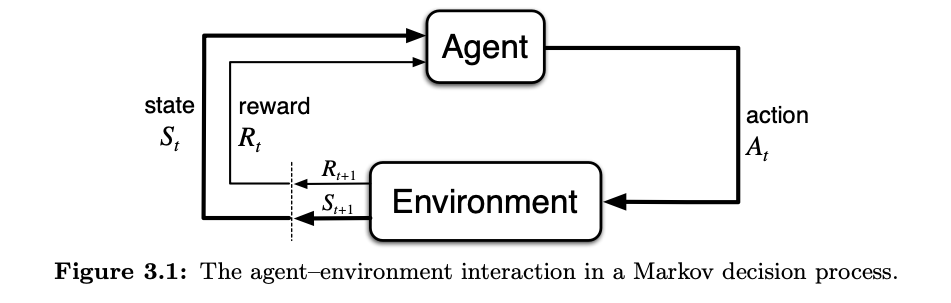

(From SB page 48)

Your task below is to implement this $\phi$ function, as well as the `reset` and `step` functions for us to gather samples of our GridWorld.

In [15]:
# [GRADED]

class FeatureGridWorld(GridWorld):
    def __init__(self, gamma: float = 0.9):
        super().__init__(gamma=gamma)
        self.current_state = None
        

    def reset(self) -> tuple[int, dict]:
        """
        Resets the current_state variable to the start state index
        and returns the index. For now we return an empty dict in
        addition to the state.
        """
    
        current_state = None
        ### START CODE HERE ###
        # start state is index 0 
        self.current_state = 0


        ### END CODE HERE ###
        return self.current_state, {}

    def featurized_reset(self) \
        -> tuple[np.ndarray, dict]:
        """
        Resets the current_state variable to the start state,
        and returns the feature vector for this start state.
        """
        start_state, flags_dict = self.reset()
        return self.phi(start_state), flags_dict


    def step(self, action: int) \
        -> tuple[int, float, bool, bool, dict]:
        """
        Takes a step in the environment by sampling from the
        transition matrix self.T given an action and the current_state and return the index of the next state.
        It returns a tuple of (next_state, reward, terminal, truncation, flags).
        You can ignore the last two arguments for now.
        For this sample-based setting, our reward function is of shape (A x S),
        where a transition to the terminal state from the rewarding state will give you the +1 or -1 reward
        for all actions.
        """
        assert self.current_state is not None, "State has not been reset"
        next_state, reward, terminal = None, None, None

        ### START CODE HERE ###
        # sample from the transition matrix to get the next state
        
        next_state = np.random.choice(self.state_size, p=self.T[action, self.current_state])
        terminal = self.terminal(next_state)
        reward = self.R[action, self.current_state]
        # reward = self.R[action, next_state]

        self.current_state = next_state



        ### END CODE HERE ###

        return self.current_state, reward, terminal, False, {}

    def phi(self, s: int) -> np.ndarray:
        """
        Given a state index, returns a feature vector of size 10,
        where the first four elements are a one-hot
        encoding of the x-position of the agent, and the last
        three elements are a one-hot encoding of hte y-position of the agent.
        The last three elements are used for both the rewarding states and the terminal state.
        """
        phi_s = None
        ### START CODE HERE ###
        phi_s = np.zeros(10)
        if s == 7:
            phi_s[-3] = 1
            return phi_s
        elif s == 11:
            phi_s[-2] = 1
            return phi_s
        elif s == 12:
            phi_s[-1] = 1
            return phi_s
        else:
            x_pos = s % 4
            y_pos = s // 4
            phi_s[x_pos] = 1
            phi_s[4 + y_pos] = 1
        



        ### END CODE HERE ###
        return phi_s

    def featurized_step(self, action: int)\
        -> tuple[np.ndarray, float, bool, bool, dict]:
        """
        Take a step but return the featurized state phi(s) instead of the next state's index.
        """
        next_state, reward, terminal, truncation_flag, flags_dict = self.step(action)
        return self.phi(next_state), reward, terminal, truncation_flag, flags_dict

    @property
    def features_size(self):
        return self.phi(0).shape[0]

Let's take a look at our new 4x3 GridWorld simulator.

In [16]:
env = FeatureGridWorld()

phi_s, _ = env.featurized_reset()
phi_s, env.current_state

(array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 0)

Let's take a few random actions in this new environment.

In [17]:
for i in range(5):
    prev_state = env.current_state
    action = np.random.choice(env.action_size)
    phi_s, reward, terminal, _, _ = env.featurized_step(action)
    print(f"s: {prev_state}, a: {action}, next_s: {env.current_state}, r: {reward}\n"
          f"phi(next_s): {phi_s}\n")

s: 0, a: 1, next_s: 1, r: 0.0
phi(next_s): [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]

s: 1, a: 2, next_s: 1, r: 0.0
phi(next_s): [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]

s: 1, a: 0, next_s: 2, r: 0.0
phi(next_s): [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]

s: 2, a: 0, next_s: 6, r: 0.0
phi(next_s): [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]

s: 6, a: 1, next_s: 10, r: 0.0
phi(next_s): [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]



## Section 2: Monte-Carlo Value Estimation
In class, we saw both a batch and incremental version of Monte Carlo (MC) value estimation **over state indices** and we want you to first implement the batch version (over state indices) below.
<!-- We derived the incremental version of value estimation through online mean estimation.  -->
This can be found in the model-free RL slides on slide number 4 under Batch Learning. There is a slightly different version of this in the textbook under algorithm 10.1. You can ignore the depth term from the algoirthm for our purposes. In summary, for a given rollout we observe the following:
$$\text{Rollout}^i = \{ s^{i}_0, a^{i}_0, r^{i}_0, s^{i}_1, ..., s^i_{T_i - 1 }, a^i_{T_i - 1}, r^{i}_{T_i - 1},  s^i_{T_i}  \}$$
Here $T_i$ is the time at which the process terminates for the $i$-th rollout. The discounted return for the $i$-th rollout and $j$-th time step is: $G^i(s_j) = \sum_{t = j}^{T_i} \gamma^{t - j}r^i_{t}$ and $G^i(s_{T_i}) = 0$. MC value estimation obtains the average discounted return a each state as follows
$$ \hat{V}(s) = \frac{1}{N} \sum_{k = 1}^N G^{k}(s), $$
by averaging over the discounted returns for the $N$ times the state $s$ appears in all rollouts. A batch MC based estimate of the return from a given state is therefore the mean of all such $G_i$ associated with a state where the state $s$ appears in the $i$-th rollout. Note that the same state can appear more than once in a rollout and an MC algorithm would average over all those instances.

In this assignment, since we add a special terminating state (state index 12), the algorithm has to set this terminal state's value to be 0. This is done because there is no reward associated with the terminal state.

In [18]:
def discounted_return(ep_rewards: np.ndarray[float], gamma) -> float:
    """
    Given an array of rewards we return the discounted return. Here, we dont
    expect you to account for terminal states being value zero. This is meant as
    a function that simply returns a sum of discounted rewards.
    """
    ### START CODE HERE ###
    total = 0
    for i in range(len(ep_rewards)):
        total += (gamma ** i) * ep_rewards[i]
    return total

    ### END CODE HERE ###

def rollout(env, pi: np.ndarray[int]) -> tuple[np.ndarray, np.ndarray]:
    """
    We take as input an environment and a policy pi. We perform a single rollout.
    This rollout takes an action according to the policy pi and transitions according
    to the step function you defined above.
    """
    #Two lists for rewards and states
    ep_states = [] # list of visited states in this episode
    ep_rewards = []

    ### START CODE HERE ###
    
    # start a new episode
    s, _ = env.reset()          
    terminal = False
    while not terminal:
        a = pi[s]   # action chosen by policy at current state
        s, r, terminal, trunc, info = env.step(a)
        ep_states.append(s)
        ep_rewards.append(r)

    return np.array(ep_states), np.array(ep_rewards)
   
    ### END CODE HERE ###

    return np.array(ep_states), np.array(ep_rewards)


def mc_policy_evaluation(env, pi: np.ndarray[int], num_samples = 1000) -> np.ndarray:
    """
    See algorithm 10.1 in the textbook (you can ignore the depth parameter there).
    We take as input the environment and a deterministic policy and return
    a value estimate array for each state.
    """
    V_mc_estimate = []

    ### START CODE HERE ###
    for state in range(env.state_size):
        returns = []
        for _ in range(num_samples):
            ep_states, ep_rewards = rollout(env, pi)
            # print("Episode states: ", ep_states)
            # print("Episode rewards: ", ep_rewards)
            # print("State being evaluated: ", state)
            if state in ep_states:
                idxs = np.where(ep_states == state)[0]
                # within an episode, if the state is visited multiple times, we want to add the discounted return for each visit to the returns list
                for idx in idxs:
                    returns.append(discounted_return(ep_rewards[idx:], env.gamma))      
        if len(returns) > 0:
            V_mc_estimate.append(np.mean(returns))
        else:
            V_mc_estimate.append(0)
    
    

    ### END CODE HERE ###

    return np.array(V_mc_estimate)

We now estimate the values for the policy from the previous homework. Remember that under this policy the agent takes the action NORTH everywhere except at state 0 where it takes the action EAST. Below we observe a single rollout followed by the MC value estimate.

In [65]:
almost_always_up_policy = np.zeros(env.state_size, dtype=int)
almost_always_up_policy[0] = 1
ep_states, ep_rewards = rollout(env, almost_always_up_policy)
ep_states_str = np.char.mod('%d', ep_states)

# We print the state transitions
print("State transitions: " + " -> ".join(ep_states_str))

State transitions: 1 -> 1 -> 2 -> 6 -> 7 -> 12


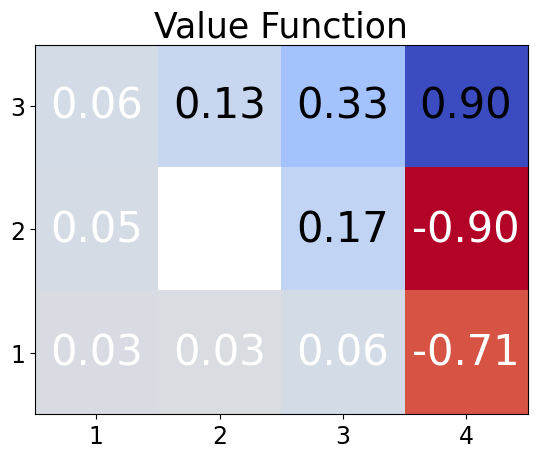

In [66]:
mc_values_estimate = mc_policy_evaluation(env, almost_always_up_policy, num_samples=5000)
plot_gridworld_u(mc_values_estimate)

Similarly, we obtain the MC estimates for the optimal policy.

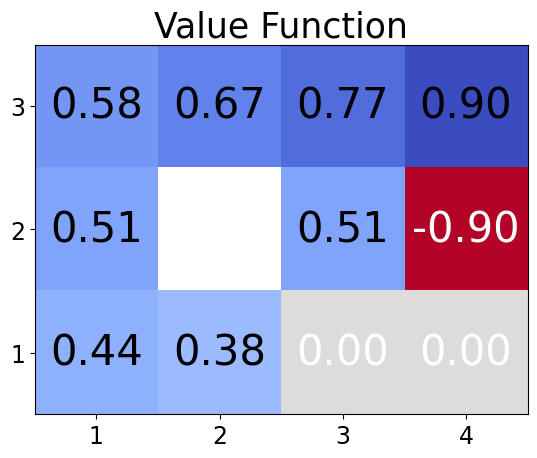

In [21]:
optimal_policy_indices = np.array([0, 3, 0, 3, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int)

optimal_mc_values_estimate = mc_policy_evaluation(env, optimal_policy_indices, num_samples=5000)
plot_gridworld_u(optimal_mc_values_estimate)

You can verify your MC estimates against the values obtained in the previous assignment. They should be pretty close.

### GRADED
2.1 You might observe that the values for certain states don't appear for the optimal policy. Besides state index 5, which states don't show a value? Why?

2.2 We have changed the reward structure in this assignment by introducing a terminal state but the values remain almost the same as the previous assignment. Why is that so? More specifically, what was the expression, in terms of $s, a, r,$ and $s',$ for values at states $11$ and $7$ in the previous MDP and what is the expression for these values now?


## Section 3: Online Monte-Carlo Value Estimation with Stochastic Gradient Descent

In this section, we'll be deriving the incremental version of the MC value estimation algorithm for **state feature vectors** with online stochastic gradient descent. Note, that we'll be using the word "incremental" and "online" interchangeably.

Stochastic gradient descent is a simple optimization algorithm ubiquitous across machine learning. It optimizes an objective function by taking steps in the gradient direction of that function with respect to a set of estimator parameters. In reinforcement learning, one objective we could consider is the __mean squared value error $\overline{VE}$__:
$$
\begin{align*}
    \overline{VE} &= \sum_{s \in S}\mu_{\pi}(s)(V^{\pi}(s) - \hat{V}(s))^2\\
    &= \mathbb{E}_{\pi}[(V^{\pi}(S) - \hat{V}(S))^2]
\end{align*}
$$
where $\mu_{\pi}(s)$ is the visitation distribution when following policy $\pi$, $V^{\pi}(s)$ is the ground-truth "target" value function at state $s$, and $\hat{V}(s)$ is the current estimate of the value function at state $s$. We re-write this objective as an expectation because we want to pay special attention to how one might __sample__ this objective. We can sample this objective by "rolling out" trajectories given a policy to follow.


Online Monte Carlo value estimation uses the above mean squared value error objective, but with a few differences.
Firstly, value estimation uses __feature vectors__, and learns a value function over these feature vectors:
$$\hat{V}(s, \mathbf{w}) = \sum_{i = 1}^{k}\mathbf{w_i}\phi_i(s).$$

Notice how we use a linear value function, linear in its parameters $w$. Besides features, the algorithm also uses **samples** of the value function $V^{\pi}(s) = \mathbb{E}_{\pi}[\sum_i\gamma^i r_i \mid s]$ as the "target" for stochastic gradient descent, like we saw above. So our new value estimation objective with a Monte Carlo target is:
$$
\begin{align*}
\overline{VE}(\mathbf{w}) &= \sum_{s \in S}\mu_{\pi}(s)(V^{\pi}(s) - \hat{V}(s, \mathbf{w}))^2\\
    &= \mathbb{E}_{\pi}\left[\left(\sum_i \gamma^i R_i - \hat{V}(S, \mathbf{w})\right)^2\right]
\end{align*}
$$
Now you are going to derive and implement online Monte Carlo value estimation yourself. As a reminder, in class we saw an incremental update rule for value estimation when we __didn't__ use feature vectors that took the form:
$$
V^{\tau + 1}(s) \leftarrow V^{\tau}(s) + \alpha (V^{\tau}(s) - V^{\pi}(s))
$$

for small $\alpha$, where $\tau$ is the number corresponding to the update. Refer to the slides for Model Free RL discussed in class.

#### GRADED
Question:

3.1 Derive the online Monte Carlo value estimation update rule from the value error objective $\overline{VE}(\mathbf{w})$. Your update rule should be in terms of $\mathbf{w}_{\tau + 1}$, where $\mathbf{w}_{\tau + 1}$ are the linear value function approximation weights at update step $\tau + 1$. Show and justify all steps of your derivation. Hint: consider the gradient of the value estimation objective with respect to the value parameters $\mathbf{w}$. What depends on $\mathbf{w}$ and what doesn't?

Now let's implement this algorithm. We've implemented a `featurized_rollout` function for you. It's your job to make use of this function to implement `online_mc`.

In [22]:
def featurized_rollout(env, pi) -> tuple[list, list]:
    """
    Featurized rollouts similar to rollouts except you now return
    the features of each state instead of the indices. The only
    difference is that we use featurized_step and featurized_reset
    instead of step and reset.
    """
    ep_rewards = []
    ep_obs = []

    obs, _, = env.featurized_reset()
    terminal = False
    ep_obs.append(obs)
    while not terminal:

        action = pi(obs)
        next_obs, reward, terminal, _, _ = env.featurized_step(action)

        ep_rewards.append(reward)
        ep_obs.append(next_obs)

        obs = next_obs

    return ep_obs, ep_rewards

def online_mc(env: FeatureGridWorld,
              pi,
              alpha: float = 0.001,
              n_runs: int = 1000) -> np.ndarray:
    """
    Online Monte Carlo value estimation with linear features.
    Your training loop should look quite similar to the example
    of calculating MSVE above.
    Learns a value function by updating the linear weights at every step
    with gradients and a learning rate \alpha by using the MC returns as
    the target. Remember to use featurized_rollout.
    """
    w = np.zeros(env.features_size)

    ### START CODE HERE ###
    
    for i in range(n_runs):
        ep_obs, ep_rewards = featurized_rollout(env, pi)
        
        # calculate discounted reward for each state in episode rollout
        returns = []
        G = 0
        # walk backwards through the episode rewards to calculate the discounted return for each state
        for r in reversed(ep_rewards):
            G = r + env.gamma * G 
            returns.insert(0, G)
            
        # update weights for each state in episode rollout
        for phi_s, G_t in zip(ep_obs[:-1], returns):
            w += alpha * (G_t - np.dot(w, phi_s)) * phi_s



    ### END CODE HERE ###

    return w

In [23]:
learnt_w_mc = online_mc(env, optimal_policy, alpha=0.001, n_runs=int(1e5))

learnt_w_mc

array([ 0.25379202,  0.30912029,  0.41356489,  0.        ,  0.23536379,
        0.31052618,  0.43058724, -0.74530384,  1.        ,  0.        ])

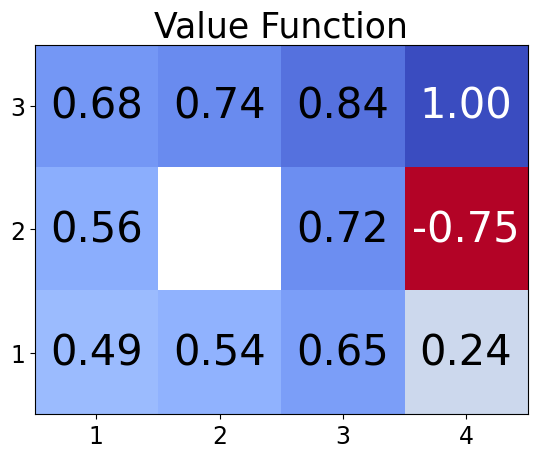

In [24]:
# Calculate our values for each state
mc_values = np.zeros(env.state_size)
for s in env.S:
    phi_s = env.phi(s)
    mc_values[s] = np.dot(phi_s, learnt_w_mc)

plot_gridworld_u(mc_values)

You can verify your MC values against the image below. Your answers won't match these reference values exactly, but should be quite close.

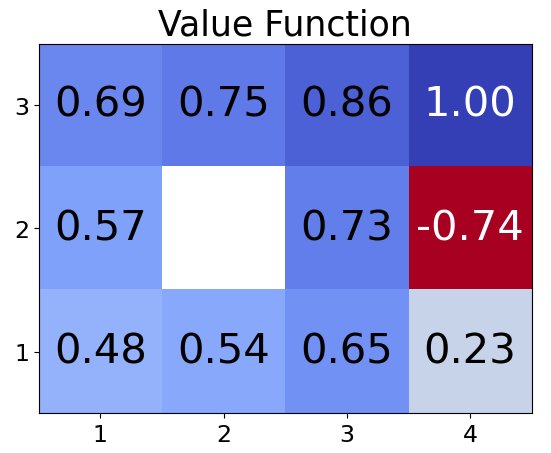

### GRADED
Question:

3.2 Now the values at the bottom right are filled in as opposed to the state index based batch MC. Why is this?

3.3 The value of the -1 state is smaller in magnitude than expected. Why is this?

3.4 Imagine instead a feature vector that's a one-hot vector of state indices (a vector with 0s everywhere, except at the current state index, which is a 1). With respect to the algorithms we have seen in class, what is `online_mc` equivalent to?

## Section 4: Temporal Difference Learning with Linear Function Approximation
Now we have the tools to examine and implement the temporal difference learning algorithm, with linear function approximation. The algorithm has one large benefit: values are able to propagate __during__ an episode, as opposed to the Monte Carlo algorithm, which required us to wait for episodes to end.

With the update rule you derived in question 3.1, we're going to do a direct drop-in replacement for the target. Instead of using $V^{\pi}(s) = \sum_i \gamma^i r_i$ as the target, we're going to use a our current guess of the value at the next state, $V^{\pi}(s) = r_i + \gamma \hat{V}^{\pi}(s', \mathbf{w})$, like we do in value determination/iteration.

This next algorithm is going to look very similar to the online MC algorithm you implemented in Section 2. There are two main changes you need to make:
1. Change your target to this new estimated target
2. Update your $\mathbf{w}$'s immediately after the `step` function, seeing as we don't need to calculate returns at the end of an episode.

In [28]:
def online_td(env: FeatureGridWorld,
              pi,
              alpha: float = 0.01,
              n_samples: int = 1000):
    """
    Temporal difference learning with linear value function approximation.
    Learns a value function by updating the linear weights at every step
    by using the 1-step estimate as the target.
    If you need a reference, check SB page 203. Once again remember to use featurized_step.
    """
    w = np.zeros(env.features_size)

    ### START CODE HERE ###
    obs, _ = env.featurized_reset()
    
    for i in range(n_samples):
        action = pi(obs)
        next_obs, reward, terminal, _, _ = env.featurized_step(action)

        # TD target
        # # if terminal, future value is 0
        td_target = reward + (0 if terminal else env.gamma * np.dot(w, next_obs))
        w += alpha * (td_target - np.dot(w, obs)) * obs
        
        # reset if terminal, or move to the next state
        if terminal:
           env.featurized_reset()[0]
        else:
            obs = next_obs

    ### END CODE HERE ###
    return w

In [29]:
learnt_w_td = online_td(env, optimal_policy, alpha=0.001, n_samples=int(1e5))

learnt_w_td

array([ 0.15344326,  0.20209578,  0.28134941,  0.        ,  0.12656585,
        0.22398288,  0.28633972, -0.10974573,  0.66474596,  0.        ])

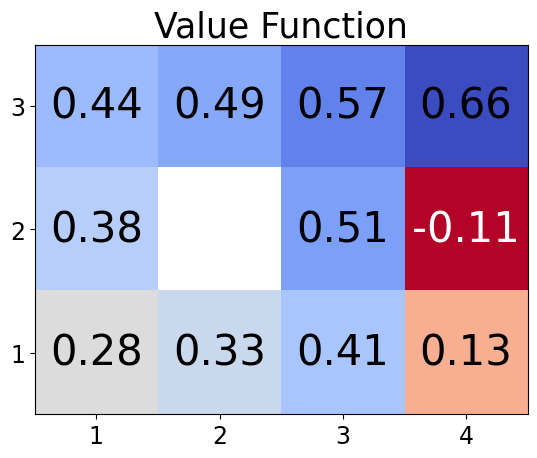

In [30]:
# Calculate our values for each state
td_values = np.zeros(env.state_size)
for s in env.S:
    phi_s = env.phi(s)
    td_values[s] = np.dot(phi_s, learnt_w_td)

plot_gridworld_u(td_values)

You can verify the values against the image below.

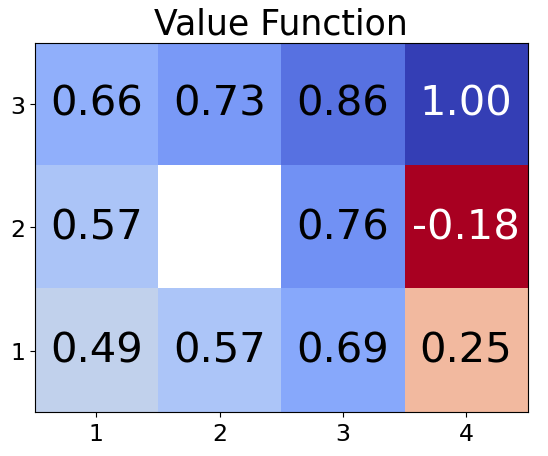

Let's think about the TD objective function we're trying to optimize:
$$
\mathbb{E}_{\pi}\left[\left((R_i + \gamma \hat{V}(S', \mathbf{w})) - \hat{V}(S, \mathbf{w})\right)^2\right]
$$
If we try to take the derivative of this term, we see that __both__ the target and estimator depend on the parameters ($\mathbf{w}$) we're taking the derivative with respect to. In most of reinforcement learning, value functions are learnt using this direct drop-in method, which only takes the gradient of the objective w.r.t. the estimate. This results in what is called a __semi-gradient__ method, since we aren't actually calculating the true gradient of the objective. While this may seem problematic, in practice there aren't many issues with using the semi-gradient.

(In fact, calculating the "true" gradient w.r.t. this objective is difficult. We refer you to chapter 11.7 in SB as a reference if this piques your interest.)

## Section 5: Semi-Gradient Control with Q-Learning
Now we move on to control. As mentioned in class, value functions are not enough for action selection. Instead, we need Q-values (or action-values) in order to gauge the utility of choosing a particular action as opposed to other actions.

Below we'll be implementing both an $\epsilon$-greedy policy and the Q-learning algorithm. While the Q-learning algorithm allows us to learn an optimal policy given the agent follows (seemingly) __any__ policy, this only works if the policy being followed (or the __behavior policy__) visits every state an infinite number of times.
If a Q-function returns you the utilities of a state over all actions, then picking the action that maximizes over all action-values may cause issues with exploration; you may end up missing important states due to this overly-greedy policy.
An $\epsilon$-greedy policy is usually the first go-to approach for resolving this issue. At any given step, an $\epsilon$-greedy policy will select the action corresponding to the maximal action-value with probability $1 - \epsilon$. Otherwise, it chooses a random action.

We'll be implementing both an $\epsilon$-greedy policy, as well as the Q-learning algorithm.

In [41]:
def eps_greedy(q_values: np.ndarray, epsilon: float = 0.1):
    """
    Sample an epsilon-greedy action. Given a set of Q-values, this
    function will sample the greedy (w.r.t. the Q-values) action
    w.p. 1 - epsilon, and with probability epsilon, will select
    a random action from ALL actions.
    """
    chosen_action = None
    ### START CODE HERE ###
    
    # sample q value actions w p 1 - epsilon, and random actions w.p. epsilon
    if np.random.rand() < epsilon:
        chosen_action = np.random.choice(len(q_values))
    else:
        chosen_action = np.argmax(q_values)
        

    ### END CODE HERE ###
    return chosen_action

def q_learning(env: FeatureGridWorld,
               alpha: float = 0.01,
               epsilon: float = 0.1,
               n_samples: int = 1000
               ) -> np.ndarray:
    """
    Q-learning with linear value function approximation and epsilon-greedy exploration.
    In this version of Q-learning, we're going to learn a set of feature weights for
    each action. This means that the weights vector in this case will be a weight
    matrix of size A x k, where k is the feature vector size. This also means that we
    only update the corresponding weight vector for each sampled action.

    REMEMBER to set your discount appropriately when terminal == True!
    """
    w = np.zeros((env.action_size, env.features_size))
    # stores weight vector per action
    ### START CODE HERE ###
    
    obs, _ = env.featurized_reset()
    for i in range(n_samples):
        q_values = w @ obs 
        
        action = eps_greedy(q_values, epsilon)
        next_obs, reward, terminal, _ , _= env.featurized_step(action)
        
        if terminal:
            td_target = reward
        else:
            td_target =  reward + env.gamma * np.max(w @ next_obs) # max over actions for next state
        
        w[action] += alpha * (td_target - q_values[action]) * obs

        
        if terminal:
            obs = env.featurized_reset()[0]
        else:
            obs = next_obs

    ### END CODE HERE ###
    return w


Now we'll run our Q-learning algorithm. A big part of reinforcement learning research is understanding the effects of hyperparameters. Try sweeping the hyperparameters below to recover the optimal policy:

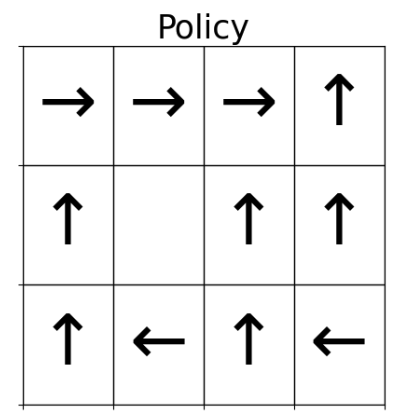

Note: yes, the optimal policy is recoverable with this feature space!

In [70]:
### MODIFY PARAMETERS BELOW ###
q_alpha = 0.005 #None
q_samples =  int(1e6) #500000 None
### ###

learnt_w_ql = q_learning(env, alpha=q_alpha, n_samples=q_samples)

learnt_w_ql

array([[ 0.32771886,  0.2735753 ,  0.38157364, -0.27976905,  0.15742588,
         0.23793621,  0.30773667, -0.98637363,  1.        ,  0.        ],
       [ 0.17269261,  0.25913433,  0.36028442, -0.02344114,  0.14809347,
         0.14389955,  0.4766772 , -0.98637363,  0.99999916,  0.        ],
       [ 0.21854037,  0.26216203,  0.21706476,  0.07005014,  0.16991293,
         0.22805287,  0.3698515 , -0.98637363,  0.99999882,  0.        ],
       [ 0.23400236,  0.23115208,  0.27875085,  0.09087475,  0.20107046,
         0.26865106,  0.36505852, -0.98644176,  0.99999872,  0.        ]])

We plot our learnt policy below.

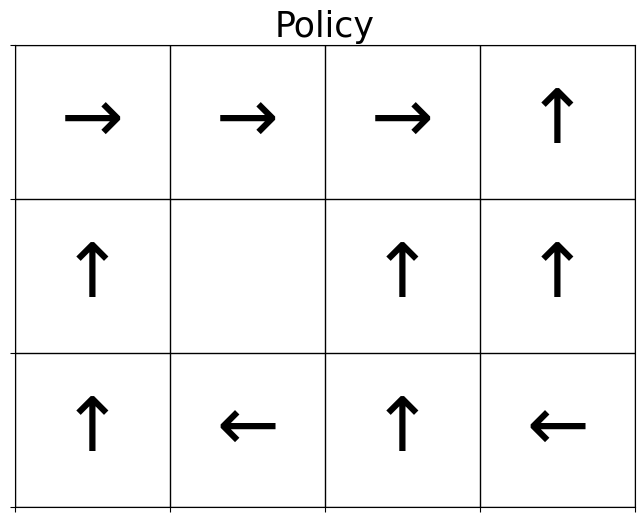

In [71]:
plot_greedy_policy(learnt_w_ql, env)

## Section 6: Q-Learning on Cart Pole
We're at the point in our understanding of reinforcement learning algorithms that we can actually solve some pretty complicated tasks. In this section, we'll be using what we've learnt to solve the Cart Pole environment.

In the Cart Pole environment, a swinging pendulum is attached to a cart. The task in this environment is to balance the pole upright, using only the movement of the cart to bring the pole upright and keep it there. The action space is two discrete actions: push the cart left or right. The reward is +1 for every time step. The environment terminates if the pole angle is too large (±12° away from straight up), or if the cart position reaches the edge of the display. Episodes are also truncated at 500 steps. You can read more about the specifics of this environment in its [documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/). This environment follows the standard Gymnasium (previously OpenAI Gym) API, which is slightly different from the API we've been using so far.

We want you to implement a featurization under which the agent obtains the optimal or near optimal policy using the Q-learning function you have implemented above. As a hint, we provide you three graphs of how the Q-values corresponding to an optimal policy depend on parameters by marginalizing over other parameters. As an example, for fixed angle, $\theta$, and angular velocity $\dot{\theta}$ we obtain the marginalised Q-value for action $a$ by estimating
$$\hat{Q}(\theta, \dot{\theta}, a) = \mathbb E_{x, \dot{x} \sim \text{Unif}} [Q([x, \dot{x}, \theta, \dot{\theta}], a ) ], $$
where $x$ is the position and $\dot{x}$ is the velocity.
In simpler terms, we estimate and visualize the Q-value averaged over positions and velocity, for the optimal policy, given the angle and the angular velocity.


You can interact with the [3D scatter plots](https://colab.research.google.com/drive/1xOKNXt0BP3S7TKhhEBq175Uiv3kFVMtH?usp=sharing). These plots visualizing the marginalised Q-values are given to you:
1. Angle, Angular Velocity vs Q-Values
2. Angle, Velocity vs Q-Values
3. Velocity, Angular Velocity vs Q-Values.

Notice how values vary differently with different features. You can intuit the features that would lead to a *linear function* to potentially fit to these curves. We have provided the hyper-parameters which would lead to the agent learning a near optimal policy if you have the appropriate featurization scheme but you are welcome to play around with them. Your code will be evaluated against our hyper-parameters and choice of features. We don't expect you to reproduce these 3D plots as the Q value function you converge upon might vary due to randomzation.

In [72]:
unwrapped_cartpole_env = gym.make('CartPole-v1', render_mode='rgb_array')

# We define a wrapper to allow your Q-learning function to work.

class FeaturizedCartPole(gym.Wrapper):
    @property
    def action_size(self):
        return self.unwrapped.action_space.n

    @property
    def features_size(self):
        return self.phi(self.unwrapped.observation_space.sample()).shape[0]

    @property
    def gamma(self):
        return 0.99

    def phi(self, s: np.ndarray):
        pos, vel, angle, angle_vel = s
        phi_s = None

        ### START CODE HERE ###
        phi_s = [1, pos, vel, angle, angle_vel,
             pos**2, vel**2, angle**2, angle_vel**2,
             angle * angle_vel]


        ### END CODE HERE ###
        return np.array(phi_s)

    def featurized_reset(self) \
            -> tuple[np.ndarray, dict]:
        start_state, flags_dict = self.reset()
        return self.phi(start_state), flags_dict

    def featurized_step(self, action):
        next_state, reward, terminal, truncation_flag, flags_dict = self.step(action)
        return self.phi(next_state), reward, terminal, truncation_flag, flags_dict

cartpole_env = FeaturizedCartPole(unwrapped_cartpole_env)

In [73]:
# You can use these hyperparameters
cartpole_q_w = q_learning(cartpole_env, alpha=0.005, epsilon=0.1, n_samples=int(1e6))
cartpole_q_w

array([[ 38.78150311, -11.70658566,  73.81054235,  33.18167894,
         32.95739809, -20.95833853, -25.78442188, -17.83644194,
         -9.74708944, -40.86546516],
       [ 42.1707039 , -12.08060304,  63.50950341,  38.58351947,
         42.70939688, -21.00136186, -33.86816406, -18.27482305,
        -15.06990606, -38.08000708]])

A near optimal policy would balance the pole in an upright position for almost 500 time time steps and has discounted return in between 95-100. We have provided code to both visualize your learned policy's behavior and return the discounted return. The code block terminates upon completion of the simulation. Please remember to install pygame for the visualizations.

Visualization Ended.


[26.029962661171943,
 31.055091413092182,
 53.411922483020604,
 28.944677272770747,
 24.528071279636716,
 38.27098590577116,
 31.055091413092182,
 26.029962661171943,
 35.08973716315973,
 30.358678195042607,
 56.13824981900886,
 48.48628825761961]

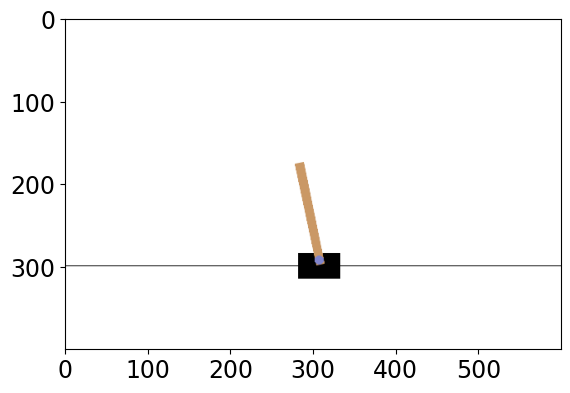

In [74]:
episode_returns = visualize_q_weight_policy(cartpole_env, cartpole_q_w, total_steps=500)
episode_returns

### GRADED

6.1 Why does a  q-learning based cartpole agent not learn the optimal policy with vanilla features (pos, vel, angle, angle_vel)?

6.2 What features did you use?

6.3 How did you infer these features from the three graphs provided above?


### Wrapping up

Congratulations! Please submit your assignment to the autograder. Remember to use the following command to export the python code. Also remember to submit a separate document for the written portion of the assignment.

```console
jupyter nbconvert --to python --RegexRemovePreprocessor.patterns="^%" CSCI2951_F_assignment2.ipynb
```

We hope you had as much fun learning from this assignment as we had creating it :)

In [77]:
# !pip install nbconvert
!jupyter nbconvert --to python --RegexRemovePreprocessor.patterns="^%" assignment2.ipynb


[NbConvertApp] Converting notebook assignment2.ipynb to python
[NbConvertApp] Writing 275379 bytes to assignment2.py
